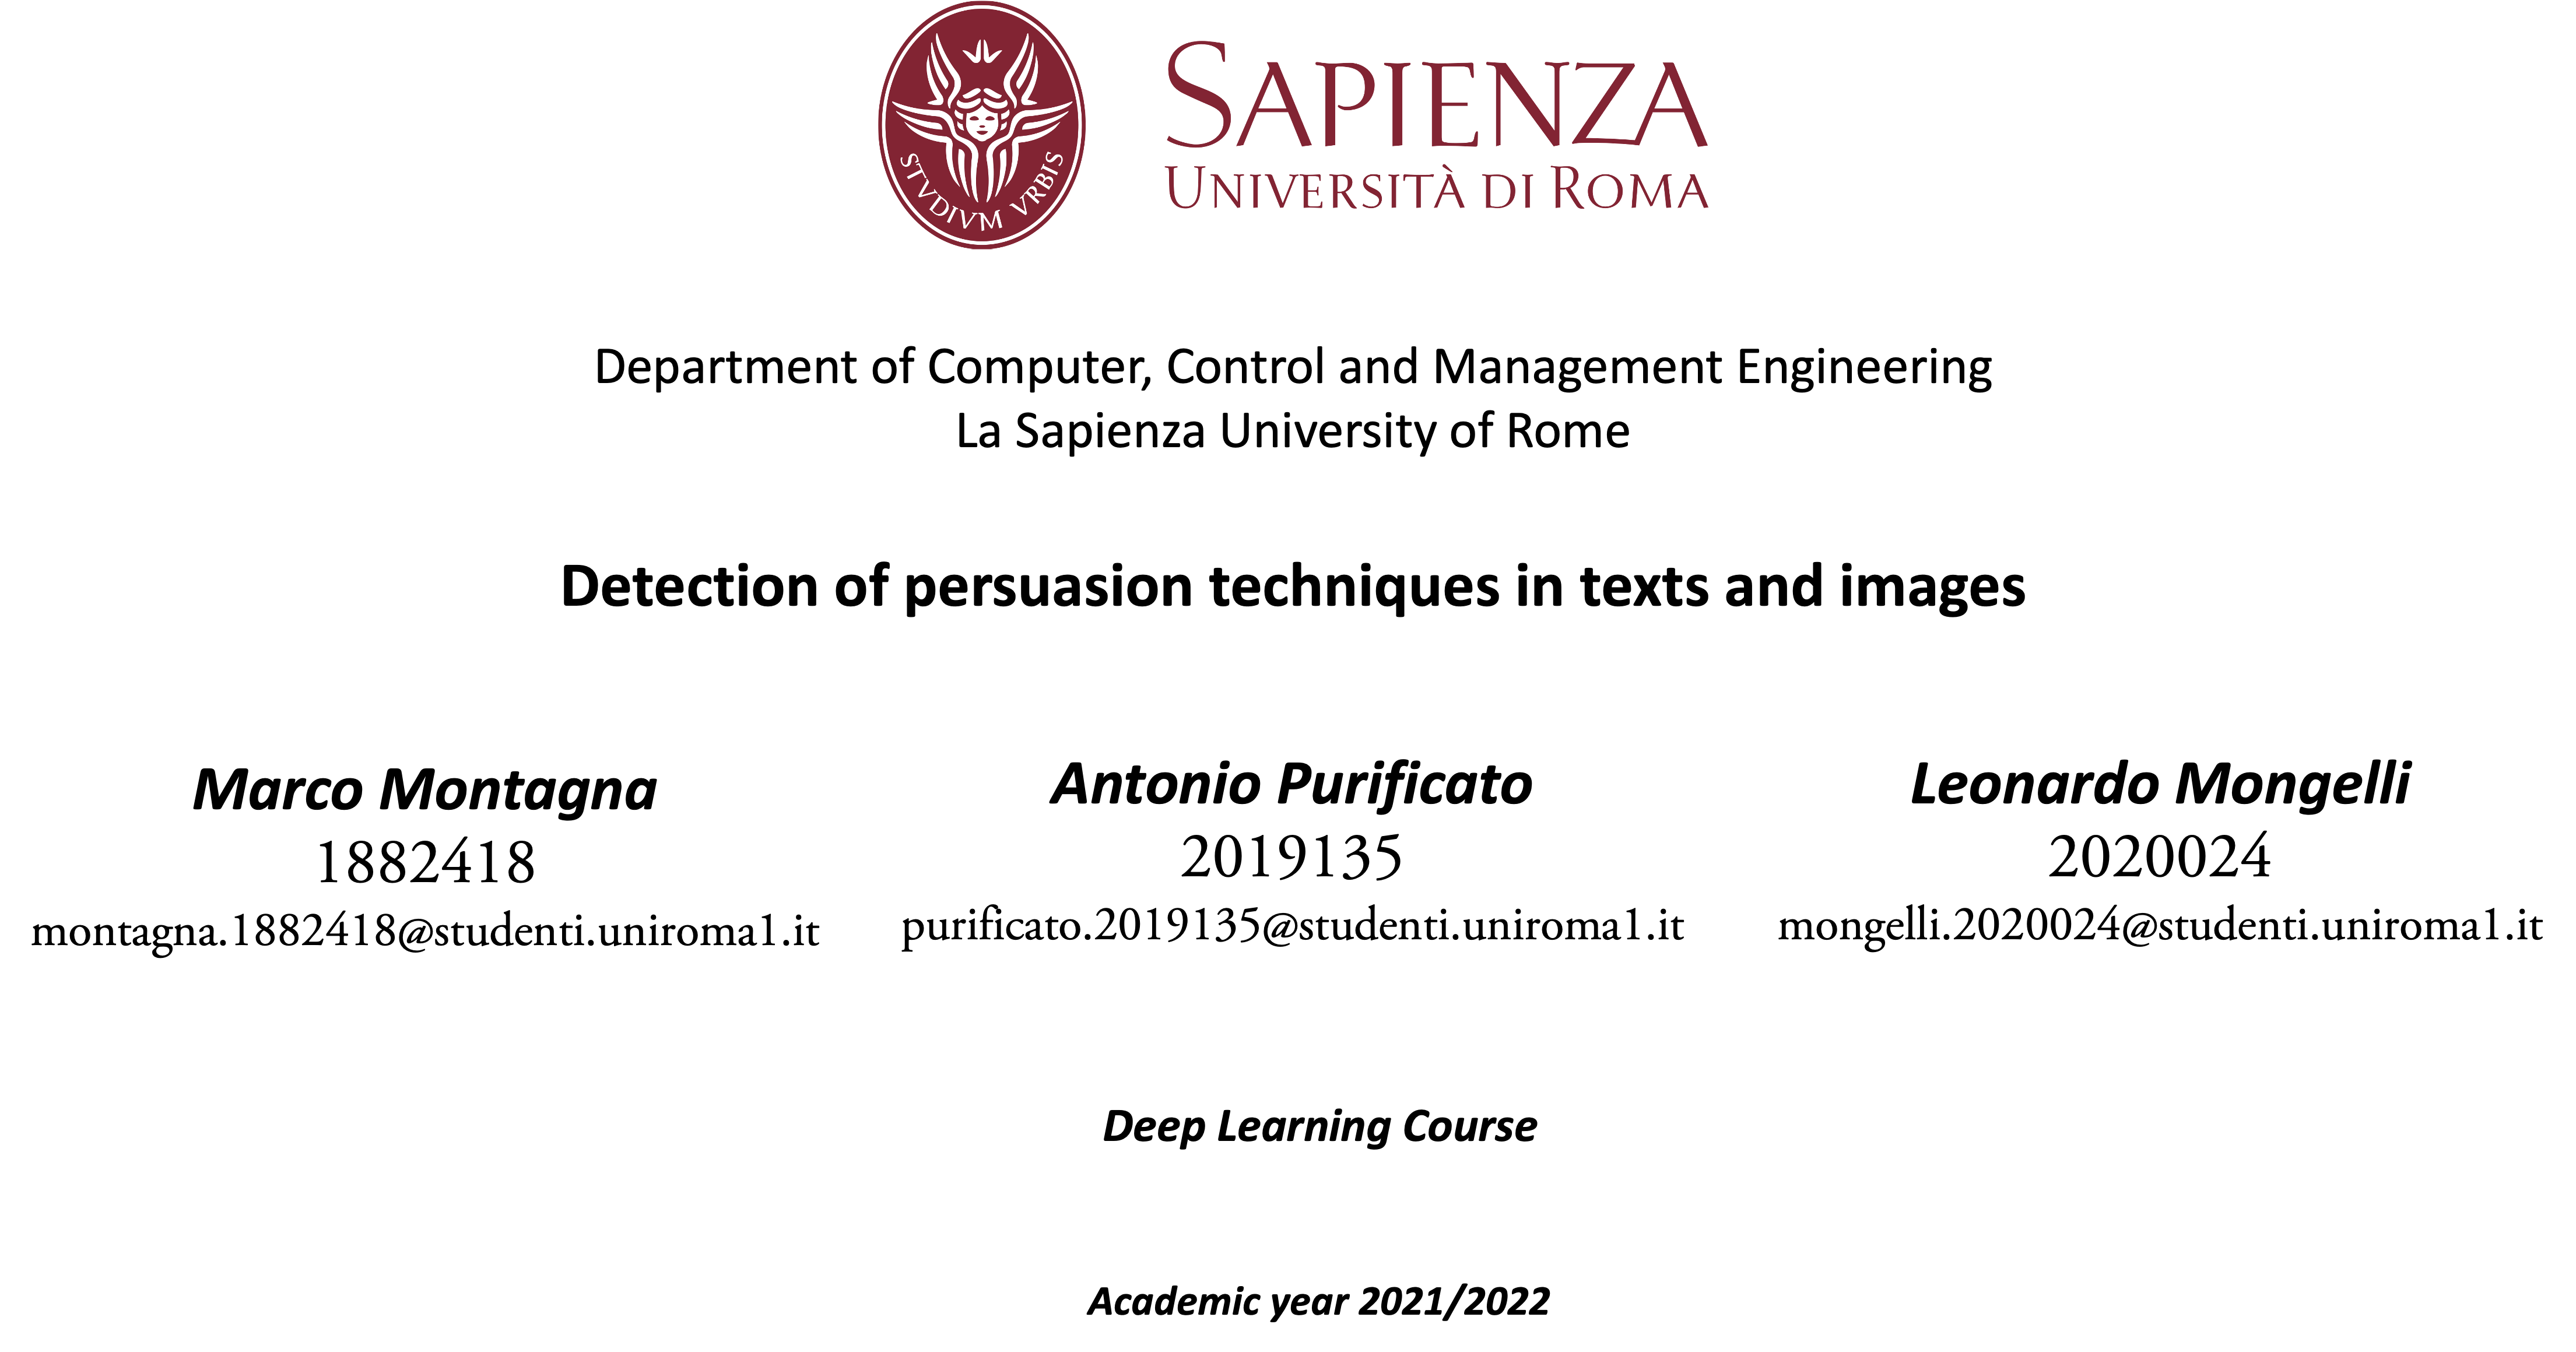

## Initialization

In [ ]:
# Mount Google Drive
from google.colab import drive  # import drive from google colab

ROOT = "/content/drive"  # default location for the drive

drive.mount(ROOT)  # we mount the google drive at /content/drive

Mounted at /content/drive


#Setup
⚠️ The first time run this cell, then comment **ONLY** it. ⚠️

In [ ]:
%%capture
!pip install -U --no-cache-dir gdown --pre
%cd /content/drive/MyDrive
!mkdir DL
%cd DL
!git clone https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus.git
%cd SEMEVAL-2021-task6-corpus/data
!unzip dev_set_task3.zip
!unzip training_set_task3.zip
!unzip test_set_task3.zip
!mv  dev_set_task3_labeled/dev_set_task3_labeled.txt .
!mv  training_set_task3/training_set_task3.txt .
!mv  test_set_task3/test_set_task3.txt .
%cd ../..

In [ ]:
%%capture
%cd ./drive/MyDrive/DL/

[Errno 2] No such file or directory: './drive/MyDrive/DL/'
/content/drive/MyDrive/DL


In [ ]:
%%capture
!pip install "pytorch-lightning" "torchmetrics" "transformers" "prettytable"

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from PIL import Image

from prettytable import PrettyTable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models import resnet50

from torchmetrics import functional

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    AutoConfig,
    get_constant_schedule_with_warmup,
)

In [ ]:
seed_everything(21)

Global seed set to 21


21

## Datasets definitions

Here the dataset classes that are going to be used in the project are defined. 

We transform the labels into fixed sized vectors by using the `MultiLabelBinarizer` function from [*sklearn.preprocessing*](https://scikit-learn.org/stable/modules/preprocessing.html). We needed two binarizer since task 1 has 20 possible labels, while task 3 has 22.

The `PersTecData` and `PersTecDataEnsemble` classes extend the *torch* `Dataset` class. 

`PersTecData` takes as input: 

* the *data_type* (= training/dev/test)
* *task* (= 1/3) 
* *tokenizer* = None
* *transforms* = None

If a tokenizer is passed the texts of the samples are saved already tokenized. Transforms instead applies the given transformation to the images, only if *task*==3.

`PersTecDataEnsemble` is similar but takes a list of tokenizers. It returns a list where each element is the text of the sample tokenized by the corresponding tokenizer, together with the corresponding label. It is used in task 1, with the ensemble of models, since each model needs a different tokenization of the input.

In [ ]:
DATA_DIR = "/content/drive/MyDrive/DL/SEMEVAL-2021-task6-corpus/data/"

In [ ]:
my_binarizer_task1 = MultiLabelBinarizer()
classes_file = "./SEMEVAL-2021-task6-corpus/techniques_list_task1-2.txt"
labels_name1 = []
with open(classes_file, "r") as f:
    for line in f.readlines():
        labels_name1.append(line.rstrip())
labels_name1.pop(-1)
labels_name1.sort()  # MultiLabelBinarizer sorts the labels
my_binarizer_task1.fit([labels_name1]);

In [ ]:
my_binarizer_task3 = MultiLabelBinarizer()
classes_file = "./SEMEVAL-2021-task6-corpus/techniques_list_task3.txt"
labels_name3 = []
with open(classes_file, "r") as f:
    for line in f.readlines():
        labels_name3.append(line.rstrip())
labels_name3.pop(-1)
labels_name3.sort()  # MultiLabelBinarizer sorts the labels
my_binarizer_task3.fit([labels_name3]);

In [ ]:
# function to load the data
def load_data(data_type, task):
    all_idxs = []
    file_name = "%s_set_task%d.txt" % (data_type, task)
    if task == 3 and data_type == "dev":
        df = pd.read_json(DATA_DIR + "dev_set_task3_labeled.txt")
    else:
        df = pd.read_json(os.path.join(DATA_DIR, file_name))
    all_idxs = df["id"].to_numpy()
    all_data = df["text"].to_numpy()
    if task == 3:
        all_images = df["image"].to_numpy()
        all_labels = my_binarizer_task3.transform(df["labels"])
    else:
        all_images = None
        all_labels = my_binarizer_task1.transform(df["labels"])
    return all_idxs, all_data, torch.tensor(all_labels), all_images

In [ ]:
# Dataset class for single models
class PersTecData(torch.utils.data.Dataset):
    def __init__(self, data_type="training", task=1, tokenizer=None, transforms=None):
        idxs, X, self.y, self.image = load_data(data_type, task)
        self.tokenized = False
        if tokenizer != None:
            self.tokenized = True
            tokenized = tokenizer(
                X.tolist(), padding="max_length", truncation=True, max_length=128
            )
            self.input_ids = torch.tensor(tokenized["input_ids"])
            self.attention_mask = torch.tensor(tokenized["attention_mask"])
        else:
            self.X = X
        self.transforms = transforms
        self.task = task
        self.data_type = data_type

    def __getitem__(self, index):
        if self.task == 3:
            if self.data_type == "training":
                path = DATA_DIR + "training_set_task3/"
            if self.data_type == "dev":
                path = DATA_DIR + "dev_set_task3_labeled/"
            if self.data_type == "test":
                path = DATA_DIR + "test_set_task3/"
            image = Image.open(path + str(self.image[index])).convert("RGB")
            image = self.transforms(image)
            if self.tokenized:
                sample = self.input_ids[index]
                mask = self.attention_mask[index]
                label = torch.squeeze(self.y[index])
                return sample, mask, label, image
            else:
                sample = self.X[index]
                label = np.squeeze(self.y[index])
                return sample, label, image
        else:
            if self.tokenized:
                sample = self.input_ids[index]
                mask = self.attention_mask[index]
                label = torch.squeeze(self.y[index])
                return sample, mask, label
            else:
                sample = self.X[index]
                label = np.squeeze(self.y[index])
                return sample, label

    def __len__(self):
        if self.tokenized:
            return self.input_ids.shape[0]
        else:
            return self.X.shape[0]

In [ ]:
# Dataset class for ensembles of models
class PersTecDataEnsemble(torch.utils.data.Dataset):
    def __init__(self, data_type="training", task=1, tokenizers=None, transforms=None):
        self.idxs, self.X, self.y, self.image = load_data(data_type, task)
        self.data_type = data_type
        self.num_tok = len(tokenizers)
        self.input_ids = []
        self.attention_mask = []
        self.task = task
        for tokenizer in tokenizers:
            tokenized = tokenizer(
                self.X.tolist(), padding="max_length", truncation=True, max_length=128
            )
            self.input_ids.append(torch.tensor(tokenized["input_ids"]))
            self.attention_mask.append(torch.tensor(tokenized["attention_mask"]))

    def __getitem__(self, index):
        elem = []
        if self.task == 3:
            if self.data_type == "training":
                path = DATA_DIR + "training_set_task3/"
            if self.data_type == "dev":
                path = DATA_DIR + "dev_set_task3_labeled/"
            if self.data_type == "test":
                path = DATA_DIR + "test_set_task3/"
            image = Image.open(path + str(self.image[index])).convert("RGB")
            image = self.transforms(image)

            for i in range(self.num_tok):
                sample = self.input_ids[i][index]
                mask = self.attention_mask[i][index]
                label = torch.squeeze(self.y[index])
                elem.append([sample, mask, label, image])
            return elem
        else:
            for i in range(self.num_tok):
                sample = self.input_ids[i][index]
                mask = self.attention_mask[i][index]
                label = torch.squeeze(self.y[index])
                elem.append([sample, mask, label])
            return elem

    def __len__(self):
        return self.X.shape[0]

## Architectures of the models

Here all the models used in this project are defined. The models used are:
* `PLMClassifier`
* `EnsembleClassifier`
* `ImageClassifier`
* `LanguageAndVisionEnsemble`
* `DVTT`

`PLMClassifier` uses a pretrained language model and fine-tunes it on the selected task. 

`EnsembleClassifier` uses a list of `PLMClassifier` and averages their results to predict. This class is only used for inference, so the models need to be trained beforehand.

`ImageClassifier` uses `ResNet50`, together with a final linear layer to classify the samples based only on the images.

`LanguageAndVisionEnsemble` (`LV`) averages the results of a language model and of an image classifier to make predictions on the samples. This class is only used for inference.

`DVTT` uses two encoders, for the textual part of the sample and the visual part. For the textual part the choice was made to return the output of the transformers of the `DeBERTa` model. For the visual part the output of the last convolutional layer of `ResNet50` is passed to an average pooling layer and the result is returned. To the image part, information about the position of the features is added with the use of the `PositionEncoder` class. The results are then mapped to a common space and two transformers are used, one for the visual part and one for the textual part. The peculiarity of these transformers is the use of the visual part to condition the textual transformer and viceversa. A linear layer maps the outputs of the transformers to a vector of the correct size. The prediction is the average of the results for both the visual and textual parts.

### `PLMClassifier` class

In [ ]:
class PLMClassifier(pl.LightningModule):
    def __init__(self, plm, output_dim=20):
        super().__init__()
        self.plm = plm
        self.learning_rate = 2e-5
        self.n_warmup_steps = 500
        self.criterion = nn.BCELoss()

    def forward(self, samples, masks):
        x = self.plm(samples, masks)
        return torch.sigmoid(x.logits)

    def training_step(self, batch, batch_idx):
        if TASK == 1:
            batch_ids, batch_mask, labels = batch
        if TASK == 3:
            batch_ids, batch_mask, labels, _ = batch
        preds = self(samples=batch_ids, masks=batch_mask)
        loss = self.criterion(preds, labels.float())
        self.log("train_loss", loss.item())
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        if TASK == 1:
            batch_ids, batch_mask, labels = batch
        if TASK == 3:
            batch_ids, batch_mask, labels, _ = batch
        preds = self(samples=batch_ids, masks=batch_mask)
        val_loss = self.criterion(preds, labels.float())
        self.log("val_loss", val_loss.item())
        return {"loss": val_loss}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = get_constant_schedule_with_warmup(
            optimizer, num_warmup_steps=self.n_warmup_steps
        )
        return dict(
            optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval="step")
        )

### `EnsembleClassifier` class

In [ ]:
class EnsembleClassifier(pl.LightningModule):
    def __init__(self, models):
        super().__init__()
        self.models = []
        for model in models:
            self.models.append(model)
        self.n_models = len(self.models)

    def forward(self, batch):
        preds = []
        for i, model in enumerate(self.models):
            samples, masks, _ = batch[i]
            device = model.device
            samples = samples.to(device)
            masks = masks.to(device)
            x = model(samples, masks)
            preds.append(x)
        preds = torch.stack(preds)
        pred = torch.mean(preds, axis=0)
        return pred

### `ImageClassifier` architecture

In [ ]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=22, lr=2e-5):
        super().__init__()
        self.lr = lr
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.BCELoss()

    def forward(self, image):
        x = self.model(image)
        return x

    def training_step(self, batch, batch_idx):
        _, _, label, image = batch
        preds = self(image)
        loss = self.criterion(preds, label.float())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        _, _, label, image = batch
        preds = self.model(image)
        loss = self.criterion(preds, label.float())
        self.log("validation_loss", loss)
        return loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = optim.Adam(self.model.fc.parameters(), lr=self.lr)
        return optimizer

`LanguageAndVisionEnsemble` architecture.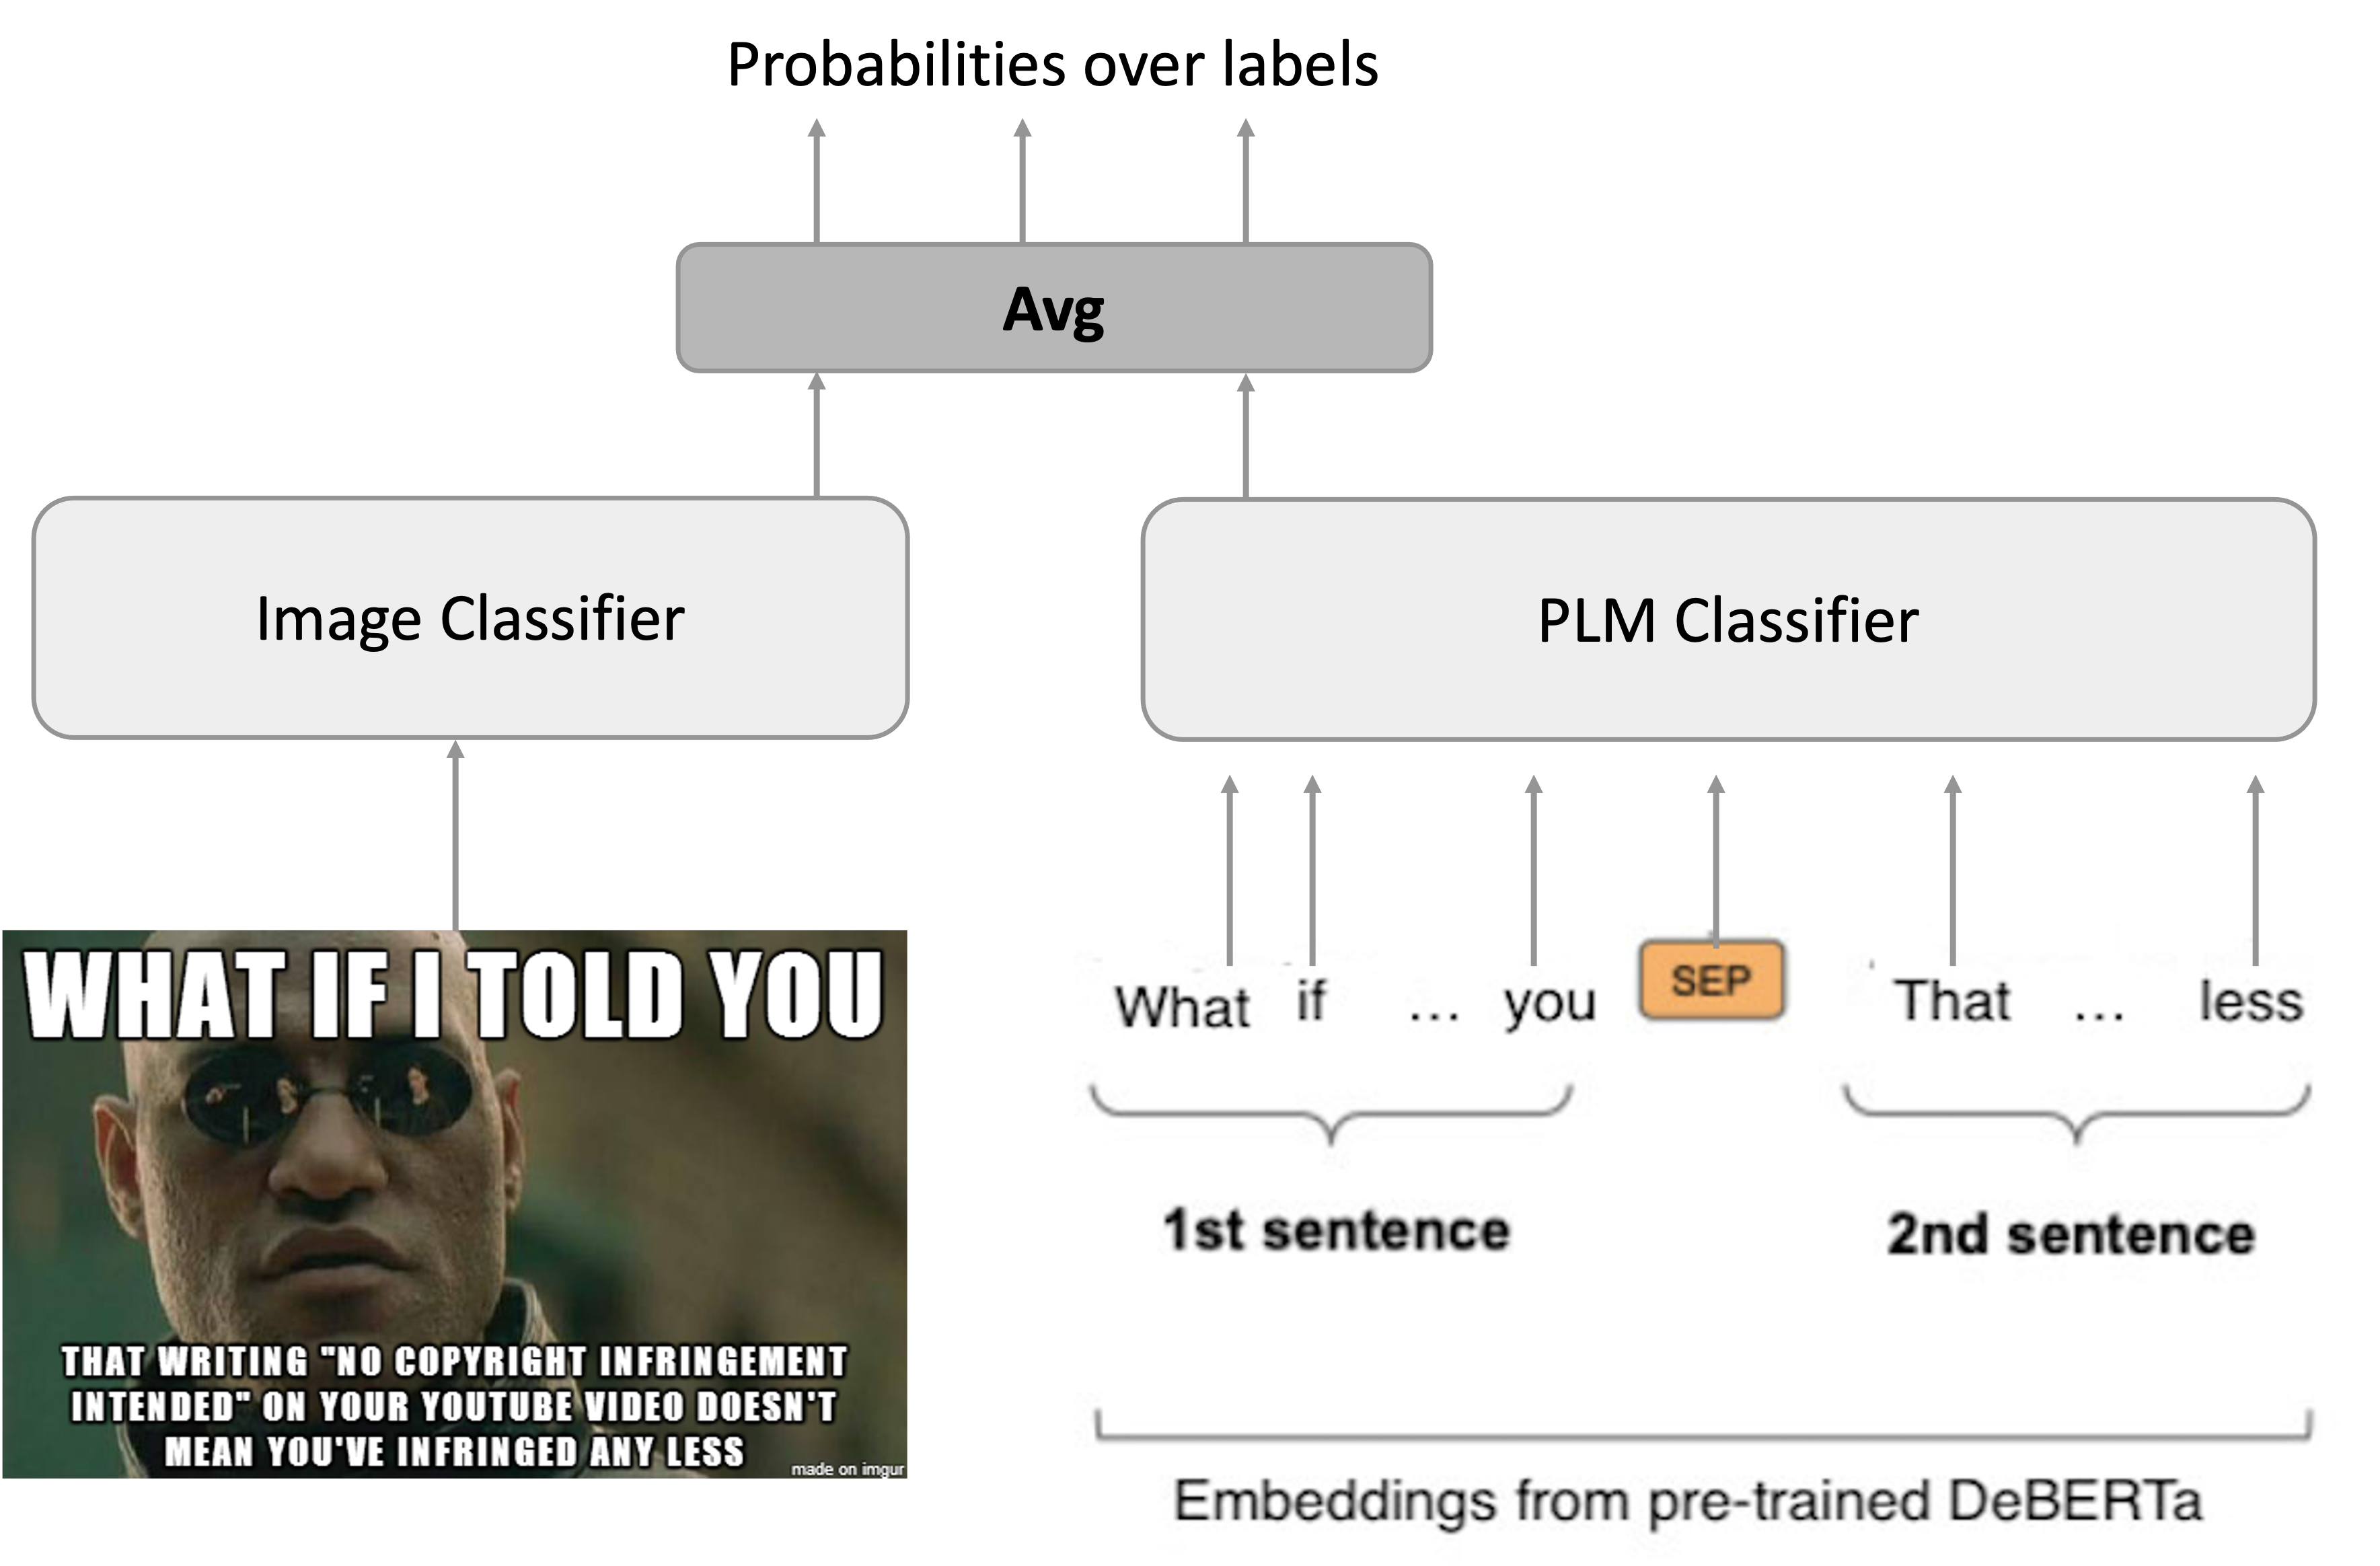



In [ ]:
class LanguageAndVisionEnsemble(pl.LightningModule):
    def __init__(
        self,
        language_classifier,
        vision_classifier,
        num_classes=22,
    ):
        super(LanguageAndVisionEnsemble, self).__init__()
        self.language_classifier = language_classifier
        self.vision_classifier = vision_classifier

    def forward(self, text, mask, image):
        text_preds = self.language_classifier(text, mask)
        image_preds = self.vision_classifier(image)
        preds = torch.mean(torch.stack([text_preds, image_preds]), dim=0)
        return preds

### Classes needed for `DVTT` 

In [ ]:
class EncoderText(nn.Module):
    def __init__(self):
        super().__init__()
        deberta_config = AutoConfig.from_pretrained(
            "microsoft/deberta-base", output_hidden_states=True, num_hidden_layers=10
        )
        self.deberta = AutoModel.from_pretrained(
            "microsoft/deberta-base", config=deberta_config
        )

    def forward(self, samples, masks):
        embedded = self.deberta(samples, masks)
        return embedded["last_hidden_state"]

    def freeze(self):
        for params in self.deberta.parameters():
            params.requires_grad = False


class EncoderImage(nn.Module):
    def __init__(self):
        super().__init__()
        my_resnet50 = resnet50(pretrained=True)
        feature_dim = my_resnet50.fc.in_features
        resnet_modules = list(my_resnet50.children())[:-2]
        self.model = nn.Sequential(*resnet_modules)
        self.avg_pooling = nn.AdaptiveAvgPool2d(7)

    def forward(self, images):
        x = self.model(images)
        x = self.avg_pooling(x)
        return x

    def freeze(self):
        for params in self.model.parameters():
            params.requires_grad = False


class PositionEncoder(nn.Module):
    def __init__(self, model_dim, grid_dim):
        super().__init__()
        self.map = nn.Linear(2, model_dim)
        self.grid_dim = grid_dim
        self.coords = self.get_coords(grid_dim)

    def get_coords(self, d):
        coords = torch.linspace(-1.0, 1.0, d)
        x = coords.unsqueeze(0).repeat(d, 1)
        y = coords.unsqueeze(1).repeat(1, d)
        # [d x d] tensor of 2D points
        points_grid = torch.stack((x, y), dim=2)
        if torch.cuda.is_available():
            points_grid = points_grid.cuda()
        return points_grid

    def forward(self, x):
        bs = x.shape[0]
        ct = self.coords.view(self.grid_dim**2, -1)  # 49 x 2
        ct = self.map(ct).unsqueeze(2)  # 49 x model_dim x 1
        ct = ct.permute(2, 1, 0)  # 1 x model_dim x 49
        ct = ct.expand(bs, -1, -1)  # B x model_dim x 49
        x = x + ct
        return x


class DualTransformer(nn.Module):
    def __init__(self, output_dim=22):
        super().__init__()
        emb_dim = 1024
        self.text_transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=4,
            num_encoder_layers=4,
            num_decoder_layers=4,
            dim_feedforward=1024,
            batch_first=True,
        )
        self.image_transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=4,
            num_encoder_layers=4,
            num_decoder_layers=4,
            dim_feedforward=1024,
            batch_first=True,
        )
        self.map_text = nn.Linear(768, emb_dim)
        self.map_image = nn.Linear(2048, emb_dim)
        self.position_encoder = PositionEncoder(2048, 7)

        self.text_head = nn.Linear(emb_dim, output_dim)
        self.image_head = nn.Linear(emb_dim, output_dim)

    def forward(self, texts, masks, images):
        txt_shape_zero = texts.shape[0]

        texts = self.map_text(texts)
        images = images.view(txt_shape_zero, images.shape[1], -1)
        images = self.position_encoder(images)
        images = images.permute(0, 2, 1)
        images = self.map_image(images)
        # forward image transformer conditioned on the text
        image_out = self.image_transformer(
            src=texts,
            tgt=images,
            src_key_padding_mask=masks,
            memory_key_padding_mask=masks,
        )
        image_feature = image_out[:, 0, :]
        image_feature = F.dropout(image_feature, 0.5)
        image_class_logits = self.image_head(image_feature)

        # forward text transformer conditioned on the image
        text_out = self.text_transformer(
            src=images, tgt=texts, tgt_key_padding_mask=masks
        )
        text_feature = text_out[:, 0, :]
        text_feature = F.dropout(text_feature, 0.5)
        text_class_logits = self.text_head(text_feature)

        text_probs = torch.sigmoid(text_class_logits)
        image_probs = torch.sigmoid(image_class_logits)
        return (text_probs + image_probs) / 2

### `DVTT` architecture  
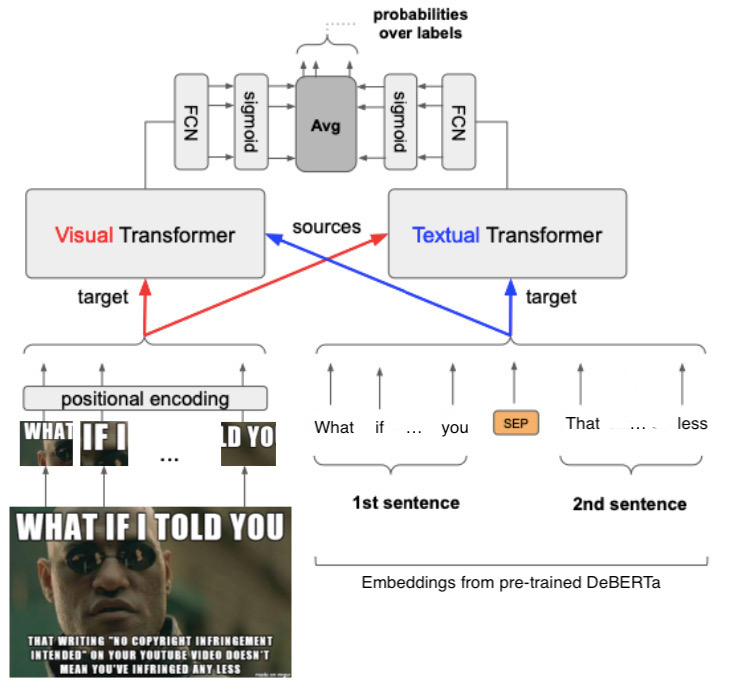

In [ ]:
class DoubleVisualTextualTransformer(pl.LightningModule):
    def __init__(self, output_dim=22, ft_vis=True, ft_text=True):
        super().__init__()
        self.visual_encoder = EncoderImage()
        self.textual_encoder = EncoderText()
        self.joining_module = DualTransformer(output_dim=output_dim)
        self.finetune_visual = ft_vis
        self.finetune_textual = ft_text
        self.learning_rate = 5e-5
        self.criterion = nn.BCELoss()

    def forward(self, text, mask, image):
        text_encoded = self.textual_encoder(text, mask)
        image_encoded = self.visual_encoder(image)
        preds = self.joining_module(text_encoded, mask, image_encoded)
        return preds

    def training_step(self, batch, batch_idx):
        batch_ids, batch_mask, labels, batch_images = batch
        preds = self(text=batch_ids, mask=batch_mask, image=batch_images)
        loss = self.criterion(preds, labels.float())
        self.log("train_loss", loss.item())
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        batch_ids, batch_mask, labels, batch_images = batch
        preds = self(text=batch_ids, mask=batch_mask, image=batch_images)
        val_loss = self.criterion(preds, labels.float())
        self.log("val_loss", val_loss.item())
        return {"loss": val_loss}

    def configure_optimizers(self):
        params = list(self.named_parameters())

        def is_backbone(n):
            return "textual_encoder" in n or "visual_encoder" in n

        grouped_parameters = [
            {
                "params": [p for n, p in params if is_backbone(n)],
                "lr": self.learning_rate / 100,
            },
            {
                "params": [p for n, p in params if not is_backbone(n)],
                "lr": self.learning_rate,
            },
        ]

        optimizer = torch.optim.Adam(grouped_parameters, lr=self.learning_rate)

        return optimizer

# TASK 1

Task 1 consists in finding the persuasion techniques used in a meme by only analizing its textual part. Our approach takes heavy inspiration from the work of the MinD group, presented in [this article](https://aclanthology.org/2021.semeval-1.150.pdf). Five different pretrained language models are used:

* `BERT`
* `RoBERTa`
* `XLNet`
* `DeBerta`
* `ALBERT`

The pretrained models are taken from [Hugging Face](https://huggingface.co/docs/transformers/index#); they are then fine-tuned on our task. At the end an ensemble is created that averages the predictions of all the models. In the tabels we can see the results obtained for this task on the validation set and on the test set.

In [ ]:
# setting global parameters used while defining the models
TASK = 1
transforms = None
NUM_LABELS = 20

## Datasets creation
Each model has its set of datasets, where each sample is tokenized with the respective tokenizer.

### Baseline datasets

In [ ]:
%%capture
dataset_train1_baseline = PersTecData(
    data_type="training", task=TASK, tokenizer=None, transforms=transforms
)

dataset_val1_baseline = PersTecData(
    data_type="dev", task=TASK, tokenizer=None, transforms=transforms
)

dataset_test1_baseline = PersTecData(
    data_type="test", task=TASK, tokenizer=None, transforms=transforms
)

### `BERT` datasets

In [ ]:
%%capture
tokenizer1 = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

dataset_train1_BERT = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer1, transforms=transforms
)
train_loader_BERT = DataLoader(
    dataset_train1_BERT, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_BERT = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer1, transforms=transforms
)
val_loader_BERT = DataLoader(
    dataset_val1_BERT, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_BERT = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer1, transforms=transforms
)
test_loader_BERT = DataLoader(
    dataset_test1_BERT, batch_size=8, num_workers=2, pin_memory=True
)

### `RoBERTa` datasets

In [ ]:
%%capture
tokenizer2 = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)
dataset_train1_RoBERTa = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer2, transforms=transforms
)
train_loader_RoBERTa = DataLoader(
    dataset_train1_RoBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_RoBERTa = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer2, transforms=transforms
)
val_loader_RoBERTa = DataLoader(
    dataset_val1_RoBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_RoBERTa = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer2, transforms=transforms
)
test_loader_RoBERTa = DataLoader(
    dataset_test1_RoBERTa, batch_size=8, num_workers=2, pin_memory=True
)

### `XLNet` datasets

In [ ]:
%%capture
tokenizer3 = AutoTokenizer.from_pretrained("xlnet-base-cased", use_fast=True)
dataset_train1_XLNet = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer3, transforms=transforms
)
train_loader_XLNet = DataLoader(
    dataset_train1_XLNet, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_XLNet = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer3, transforms=transforms
)
val_loader_XLNet = DataLoader(
    dataset_val1_XLNet, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_XLNet = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer3, transforms=transforms
)
test_loader_XLNet = DataLoader(
    dataset_test1_XLNet, batch_size=8, num_workers=2, pin_memory=True
)

### `DeBERTa` datasets

In [ ]:
%%capture
tokenizer4 = AutoTokenizer.from_pretrained("microsoft/deberta-base", use_fast=True)
dataset_train1_DeBERTa = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer4, transforms=transforms
)
train_loader_DeBERTa = DataLoader(
    dataset_train1_DeBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_DeBERTa = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer4, transforms=transforms
)
val_loader_DeBERTa = DataLoader(
    dataset_val1_DeBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_DeBERTa = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer4, transforms=transforms
)
test_loader_DeBERTa = DataLoader(
    dataset_test1_DeBERTa, batch_size=8, num_workers=2, pin_memory=True
)

###`AlBERT` datasets

In [ ]:
%%capture
tokenizer5 = AutoTokenizer.from_pretrained("albert-base-v2", use_fast=True)
dataset_train1_ALBERT = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer5, transforms=transforms
)
train_loader_ALBERT = DataLoader(
    dataset_train1_ALBERT, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_ALBERT = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer5, transforms=transforms
)
val_loader_ALBERT = DataLoader(
    dataset_val1_ALBERT, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_ALBERT = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer5, transforms=transforms
)
test_loader_ALBERT = DataLoader(
    dataset_test1_ALBERT, batch_size=8, num_workers=2, pin_memory=True
)

### Ensemble datasets

In [ ]:
dataset_val1_ensemble = PersTecDataEnsemble(
    data_type="dev",
    task=TASK,
    tokenizers=[tokenizer1, tokenizer2, tokenizer3, tokenizer4, tokenizer5],
    transforms=transforms,
)
val_loader_ensemble = DataLoader(
    dataset_val1_ensemble, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_ensemble = PersTecDataEnsemble(
    data_type="test",
    task=TASK,
    tokenizers=[tokenizer1, tokenizer2, tokenizer3, tokenizer4, tokenizer5],
    transforms=transforms,
)
test_loader_ensemble = DataLoader(
    dataset_test1_ensemble, batch_size=8, num_workers=2, pin_memory=True
)

### Looking at the data

We briefly look at the data. The tokenized versions of the texts have *max_length* (128) elements, like we expected. The labels are binarized correctly.

By looking a the whole dataset we see that it is not balanced, with some classes appearing much more frequently than others.

In [ ]:
print(dataset_train1_BERT.input_ids[0])
print(tokenizer1.convert_ids_to_tokens(dataset_train1_BERT.input_ids[0]))
label = dataset_train1_BERT.y[0]
print(label)
print(my_binarizer_task1.inverse_transform(label.reshape(1, -1)))

tensor([ 101, 2045, 2024, 2069, 2048, 5907, 2015, 2931, 3287,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
['[CLS]', 'there', 'are', 'only', 'two', 'gender', '##s', 'female', 'male', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

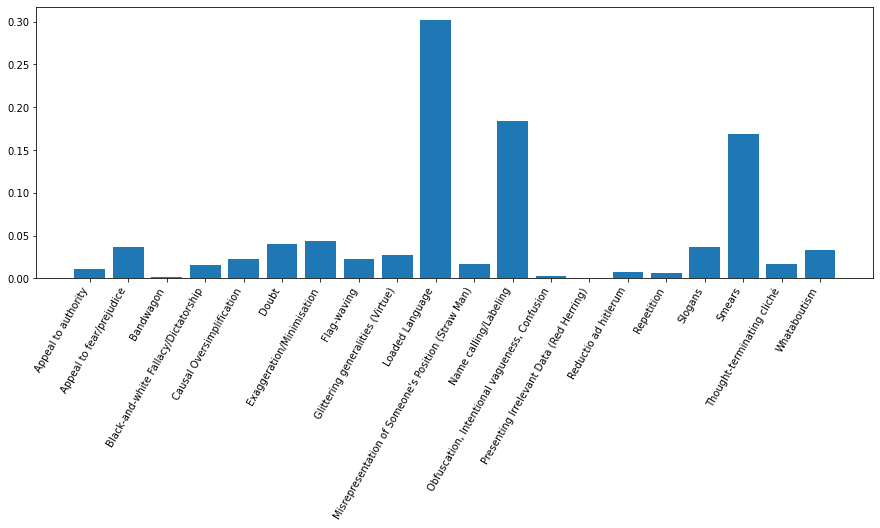

In [ ]:
label_dist = torch.sum(dataset_train1_BERT.y, axis=0)
label_dist_norm = label_dist / torch.sum(label_dist)
fig = plt.figure(figsize=(15, 5))
plt.bar(labels_name1, label_dist_norm)
plt.xticks(rotation=60, ha="right");

## Random baseline

We implemented two random baselines: the first one has probability of each label of a sample being one, equal to the fraction of samples having that label. The second baseline has probability 0.5 of each label being one.

In [ ]:
class random_baseline(pl.LightningModule):
    def __init__(self, data_dist):
        super().__init__()
        self.data_dist = data_dist

    def forward(self, x):
        rand = torch.rand(x.shape[0], self.data_dist.shape[0])
        return torch.less(rand, self.data_dist)

    def test_step(self, batch, batch_idx):
        x, mask, y = batch
        y_hat = self(x)
        return y, y_hat

    def test(self, data_loader):
        true_labels = []
        predictions = []
        for i, batch in enumerate(data_loader):
            y, y_hat = self.test_step(batch, i)
            true_labels.append(y)
            predictions.append(y_hat)
        true_labels = torch.cat(true_labels)
        predictions = torch.cat(predictions)
        macro_f1 = f1_score(true_labels, predictions, average="macro", zero_division=1)
        micro_f1 = f1_score(true_labels, predictions, average="micro", zero_division=1)
        return macro_f1, micro_f1

In [ ]:
f1_macro = []
f1_micro = []
rb = random_baseline(label_dist_norm)
for i in range(20):
    f1_macro_temp, f1_micro_temp = rb.test(train_loader_RoBERTa)
    f1_macro.append(f1_macro_temp)
    f1_micro.append(f1_micro_temp)
print(
    "Random baseline \n  f1-macro %.5f+-%.5f\n  f1-micro %.5f+-%.5f"
    % (np.mean(f1_macro), np.std(f1_macro), np.mean(f1_micro), np.std(f1_micro))
)


f1_macro = []
f1_micro = []
rb2 = random_baseline(torch.ones(20) / 2)
for i in range(20):
    f1_macro_temp, f1_micro_temp = rb2.test(train_loader_RoBERTa)
    f1_macro.append(f1_macro_temp)
    f1_micro.append(f1_micro_temp)
print(
    "Random baseline 2 \n  f1-macro %.5f+-%.5f\n  f1-micro %.5f+-%.5f"
    % (np.mean(f1_macro), np.std(f1_macro), np.mean(f1_micro), np.std(f1_micro))
)

Random baseline 
  f1-macro 0.06326+-0.01118
  f1-micro 0.20791+-0.01109
Random baseline 2 
  f1-macro 0.11671+-0.00273
  f1-micro 0.14615+-0.00379


## Baseline 2 - Random Forest

In [ ]:
# vectorization removes all words that appear only once in the dataset
vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit(
    np.concatenate(
        [dataset_train1_baseline.X, dataset_val1_baseline.X, dataset_test1_baseline.X]
    )
)
X_train = vectorizer.transform(dataset_train1_baseline.X)
X_val = vectorizer.transform(dataset_val1_baseline.X)
X_test = vectorizer.transform(dataset_test1_baseline.X)

In [ ]:
model = RandomForestClassifier(
    n_estimators=200,
    criterion="entropy",
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=21,
    max_samples=1.0,
)

In [ ]:
grid_search_classification = GridSearchCV(
    model,
    {"min_samples_leaf": [20, 50, 100], "max_samples": [0.3, 0.5, 1]},
    cv=5,
    scoring="f1_micro",
    verbose=1,
    n_jobs=-1,
)

grid_search_classification.fit(X_train, dataset_train1_baseline.y)

print("Best parameters for our model:")
print(grid_search_classification.best_params_)
print("F1 score for the best model:")
print(grid_search_classification.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for our model:
{'max_samples': 0.3, 'min_samples_leaf': 50}
F1 score for the best model:
0.38415685976230024


In [ ]:
predictions = torch.tensor(grid_search_classification.predict(X_val))
macro_f1_val = f1_score(
    dataset_val1_baseline.y, predictions, average="macro", zero_division=1
)
micro_f1_val = f1_score(
    dataset_val1_baseline.y, predictions, average="micro", zero_division=1
)

print("Validation set")
print("Macro-F1:")
print(format(macro_f1_val, ".5f"))
print("Micro-F1:")
print(format(micro_f1_val, ".5f"))

Validation set
Macro-F1:
0.18298
Micro-F1:
0.33333


In [ ]:
predictions = torch.tensor(grid_search_classification.predict(X_test))
macro_f1 = f1_score(
    dataset_test1_baseline.y, predictions, average="macro", zero_division=1
)
micro_f1 = f1_score(
    dataset_test1_baseline.y, predictions, average="micro", zero_division=1
)

print("Test set")
print("Macro-F1:")
print(format(macro_f1, ".5f"))
print("Micro-F1:")
print(format(micro_f1, ".5f"))

Test set
Macro-F1:
0.03333
Micro-F1:
0.37383


## Model implementation


In [ ]:
%%capture
bert = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=NUM_LABELS
)
model_bert = PLMClassifier(bert)
roberta = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=NUM_LABELS
)
model_roberta = PLMClassifier(roberta)
xlnet = AutoModelForSequenceClassification.from_pretrained(
    "xlnet-base-cased", num_labels=NUM_LABELS
)
model_xlnet = PLMClassifier(xlnet)
deberta = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-base", num_labels=NUM_LABELS
)
model_deberta = PLMClassifier(deberta)
albert = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2", num_labels=NUM_LABELS
)
model_albert = PLMClassifier(albert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Loading checkpoints
In this notebook pre-trained architectures are used, this way the notebook is neater and there are no problems of computational resources. Below you can look at the notebooks used for training the networks:

* Notebook 1  
<a href="https://github.com/Coerulatus/Detection-of-persuasive-techniques-in-memes/blob/main/training_notebooks/Training_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Notebook 1"/></a>

* Notebook 2  
<a href="https://github.com/Coerulatus/Detection-of-persuasive-techniques-in-memes/blob/main/training_notebooks/Training_Notebook2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [ ]:
class ckpt_path:
    def __init__(self, path):
        self.best_model_path = path


checkpoint_callback1 = ckpt_path(
    "tb_logs/BERTClassifier/version_0/checkpoints/BERT.ckpt"
)
checkpoint_callback2 = ckpt_path(
    "tb_logs/RoBERTaClassifier/version_0/checkpoints/ROBERTA.ckpt"
)
checkpoint_callback3 = ckpt_path(
    "tb_logs/XLNetClassifier/version_0/checkpoints/XLNET.ckpt"
)
checkpoint_callback4 = ckpt_path(
    "tb_logs/DeBERTaClassifier/version_0/checkpoints/DEBERTA.ckpt"
)
checkpoint_callback5 = ckpt_path(
    "tb_logs/ALBERTClassifier/version_0/checkpoints/ALBERT.ckpt"
)

print(checkpoint_callback1.best_model_path)
print(checkpoint_callback2.best_model_path)
print(checkpoint_callback3.best_model_path)
print(checkpoint_callback4.best_model_path)
print(checkpoint_callback5.best_model_path)

tb_logs/BERTClassifier/version_0/checkpoints/BERT.ckpt
tb_logs/RoBERTaClassifier/version_0/checkpoints/ROBERTA.ckpt
tb_logs/XLNetClassifier/version_0/checkpoints/XLNET.ckpt
tb_logs/DeBERTaClassifier/version_0/checkpoints/DEBERTA.ckpt
tb_logs/ALBERTClassifier/version_0/checkpoints/ALBERT.ckpt


In [ ]:
# BERT checkpoint
model_bert.load_from_checkpoint(checkpoint_callback1.best_model_path, plm=bert)

# RoBERTa checkpoint
model_roberta.load_from_checkpoint(checkpoint_callback2.best_model_path, plm=roberta)

# XLNet checkpoint
model_xlnet.load_from_checkpoint(checkpoint_callback3.best_model_path, plm=xlnet)

# DeBERTa checkpoint
model_deberta.load_from_checkpoint(checkpoint_callback4.best_model_path, plm=deberta)

# AlBERT checkpoint
model_albert.load_from_checkpoint(checkpoint_callback5.best_model_path, plm=albert);

## Ensemble
An ensemble is defined using using the class `Ensemble_Classifier` and the five pre-trained models .

In [ ]:
ensemble = EnsembleClassifier(
    [model_bert, model_roberta, model_xlnet, model_deberta, model_albert]
)

## Testing models
The performance metrics used for this this project are the ${Micro-F_1}$ and ${Macro-F_1}$.  
The difference between ${Micro-F_1}$ and ${Macro-F_1}$ scores lies in the way $precision$ and $recall$ are computed: in ${Micro-F_1}$, they are computed from all the
$true\ positives$, $false\ positives$, and $false\ negatives$
over all the labels; for this reason, ${Micro-F_1}$ gives
each sample the same weight, thus giving more
emphasis to the most frequent labels. On the other
hand, ${Macro-F_1}$ is computed as the mean value
among the $F_1-scores$ computed on the different
labels.

### Testing function definition


In [ ]:
def test_classifier(model, data_loader, thresholds, n_models=1):
    model.cuda()
    model.eval()
    micro_f1 = []
    macro_f1 = []
    outputs = []
    true_labels = []
    for i, batch in enumerate(data_loader):
        if n_models == 1:
            batch_ids, batch_mask, labels = batch
            true_labels.append(labels)
            outputs.append(model(batch_ids.cuda(), batch_mask.cuda()).detach().cpu())
        else:
            labels = batch[0][2]
            true_labels.append(labels)
            outputs.append(model(batch).detach().cpu())
    true_labels = torch.cat(true_labels)
    outputs = torch.cat(outputs)
    # print(outputs)
    for threshold in thresholds:
        predictions = torch.greater(outputs, torch.ones(outputs.shape) * threshold)
        # num_pred = [[1 if x else 0 for x in p] for p in predictions]
        # print(np.sum(num_pred,axis=0))
        macro_f1.append(
            f1_score(true_labels, predictions, average="macro", zero_division=1)
        )
        micro_f1.append(
            f1_score(true_labels, predictions, average="micro", zero_division=1)
        )

    return macro_f1, micro_f1

### Validation dataset performance

In [ ]:
thresholds = [x / 10 for x in range(0, 11)]

val_table = PrettyTable(["Model", "Micro F-1", "Macro F-1"])
val_table.title = "Validation set results"


macro_f1_bert_val, micro_f1_bert_val = test_classifier(
    model_bert, val_loader_BERT, thresholds
)

macro_f1_roberta_val, micro_f1_roberta_val = test_classifier(
    model_roberta, val_loader_RoBERTa, thresholds
)

macro_f1_xlnet_val, micro_f1_xlnet_val = test_classifier(
    model_xlnet, val_loader_XLNet, thresholds
)

macro_f1_deberta_val, micro_f1_deberta_val = test_classifier(
    model_deberta, val_loader_DeBERTa, thresholds
)

macro_f1_albert_val, micro_f1_albert_val = test_classifier(
    model_albert, val_loader_ALBERT, thresholds
)

macro_f1_ensemble_val, micro_f1_ensemble_val = test_classifier(
    ensemble, val_loader_ensemble, thresholds, n_models=ensemble.n_models
)

val_table.add_row(
    [
        "BERT",
        str(format(max(micro_f1_bert_val), ".5f")),
        str(format(max(macro_f1_bert_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "RoBERTa",
        str(format(max(micro_f1_roberta_val), ".5f")),
        str(format(max(macro_f1_roberta_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "XLNet",
        str(format(max(micro_f1_xlnet_val), ".5f")),
        str(format(max(macro_f1_xlnet_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "DeBERTa",
        str(format(max(micro_f1_deberta_val), ".5f")),
        str(format(max(macro_f1_deberta_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "AlBERT",
        str(format(max(micro_f1_albert_val), ".5f")),
        str(format(max(macro_f1_albert_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "Ensemble",
        str(format(max(micro_f1_ensemble_val), ".5f")),
        str(format(max(macro_f1_ensemble_val), ".5f")),
    ]
)

print(val_table)

+----------------------------------+
|      Validation set results      |
+----------+-----------+-----------+
|  Model   | Micro F-1 | Macro F-1 |
+----------+-----------+-----------+
|   BERT   |  0.58874  |  0.25728  |
| RoBERTa  |  0.59072  |  0.31740  |
|  XLNet   |  0.56170  |  0.25206  |
| DeBERTa  |  0.57708  |  0.25304  |
|  AlBERT  |  0.57522  |  0.25915  |
| Ensemble |  0.59193  |  0.27874  |
+----------+-----------+-----------+


####F1-Micro

Text(0, 0.5, 'f1-micro')

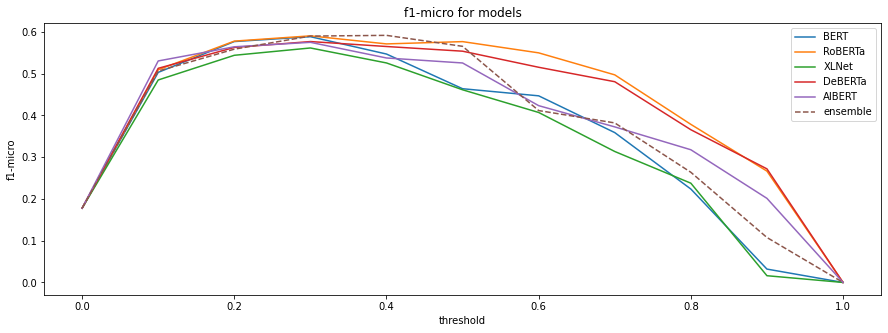

In [ ]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, micro_f1_bert_val, label="BERT")
plt.plot(thresholds, micro_f1_roberta_val, label="RoBERTa")
plt.plot(thresholds, micro_f1_xlnet_val, label="XLNet")
plt.plot(thresholds, micro_f1_deberta_val, label="DeBERTa")
plt.plot(thresholds, micro_f1_albert_val, label="AlBERT")
plt.plot(thresholds, micro_f1_ensemble_val, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-micro for models")
plt.xlabel("threshold")
plt.ylabel("f1-micro")

####F1-Macro

Text(0, 0.5, 'f1-macro')

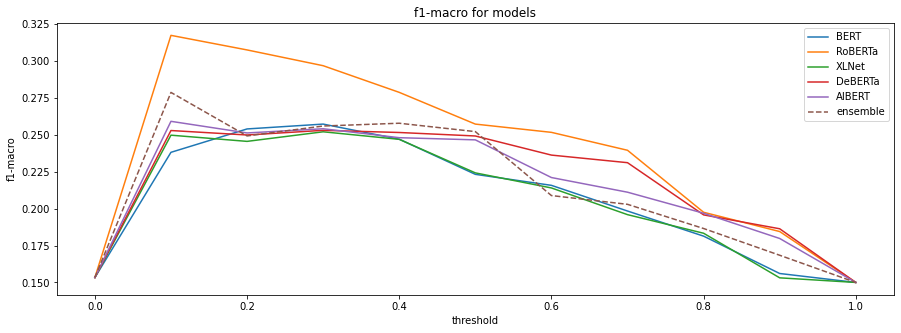

In [ ]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, macro_f1_bert_val, label="BERT")
plt.plot(thresholds, macro_f1_roberta_val, label="RoBERTa")
plt.plot(thresholds, macro_f1_xlnet_val, label="XLNet")
plt.plot(thresholds, macro_f1_deberta_val, label="DeBERTa")
plt.plot(thresholds, macro_f1_albert_val, label="AlBERT")
plt.plot(thresholds, macro_f1_ensemble_val, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-macro for models")
plt.xlabel("threshold")
plt.ylabel("f1-macro")

### Test dataset performance

In [ ]:
thresholds = [x / 10 for x in range(0, 11)]

test_table = PrettyTable(["Model", "Micro F-1", "Macro F-1"])
test_table.title = "Test set results"

macro_f1_bert, micro_f1_bert = test_classifier(model_bert, test_loader_BERT, thresholds)

macro_f1_roberta, micro_f1_roberta = test_classifier(
    model_roberta, test_loader_RoBERTa, thresholds
)

macro_f1_xlnet, micro_f1_xlnet = test_classifier(
    model_xlnet, test_loader_XLNet, thresholds
)

macro_f1_deberta, micro_f1_deberta = test_classifier(
    model_deberta, test_loader_DeBERTa, thresholds
)

macro_f1_albert, micro_f1_albert = test_classifier(
    model_albert, test_loader_ALBERT, thresholds
)

macro_f1_ensemble, micro_f1_ensemble = test_classifier(
    ensemble, test_loader_ensemble, thresholds, n_models=ensemble.n_models
)

test_table.add_row(
    [
        "BERT",
        str(format(max(micro_f1_bert), ".5f")),
        str(format(max(macro_f1_bert), ".5f")),
    ]
)
test_table.add_row(
    [
        "RoBERTa",
        str(format(max(micro_f1_roberta), ".5f")),
        str(format(max(macro_f1_roberta), ".5f")),
    ]
)
test_table.add_row(
    [
        "XLNet",
        str(format(max(micro_f1_xlnet), ".5f")),
        str(format(max(macro_f1_xlnet), ".5f")),
    ]
)
test_table.add_row(
    [
        "DeBERTa",
        str(format(max(micro_f1_deberta), ".5f")),
        str(format(max(macro_f1_deberta), ".5f")),
    ]
)
test_table.add_row(
    [
        "ALBERT",
        str(format(max(micro_f1_albert), ".5f")),
        str(format(max(macro_f1_albert), ".5f")),
    ]
)
test_table.add_row(
    [
        "Ensemble",
        str(format(max(micro_f1_ensemble), ".5f")),
        str(format(max(macro_f1_ensemble), ".5f")),
    ]
)

print(test_table)

+----------------------------------+
|         Test set results         |
+----------+-----------+-----------+
|  Model   | Micro F-1 | Macro F-1 |
+----------+-----------+-----------+
|   BERT   |  0.49153  |  0.13651  |
| RoBERTa  |  0.49462  |  0.15356  |
|  XLNet   |  0.46416  |  0.13651  |
| DeBERTa  |  0.50968  |  0.13651  |
|  ALBERT  |  0.48993  |  0.13651  |
| Ensemble |  0.50772  |  0.13651  |
+----------+-----------+-----------+


####F-1 Micro

Text(0, 0.5, 'f1-micro')

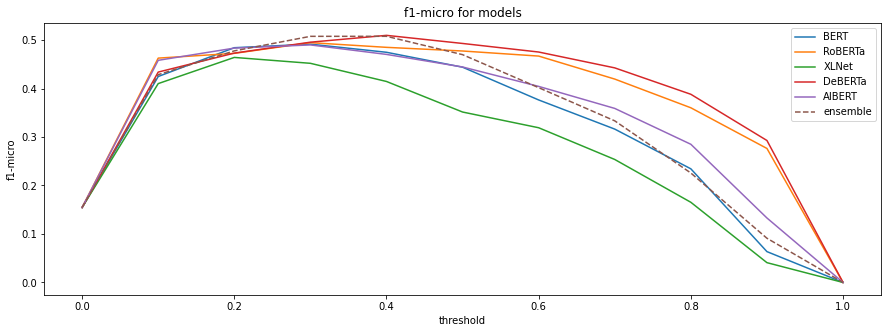

In [ ]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, micro_f1_bert, label="BERT")
plt.plot(thresholds, micro_f1_roberta, label="RoBERTa")
plt.plot(thresholds, micro_f1_xlnet, label="XLNet")
plt.plot(thresholds, micro_f1_deberta, label="DeBERTa")
plt.plot(thresholds, micro_f1_albert, label="AlBERT")
plt.plot(thresholds, micro_f1_ensemble, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-micro for models")
plt.xlabel("threshold")
plt.ylabel("f1-micro")

####F-1 Macro

Text(0, 0.5, 'f1-macro')

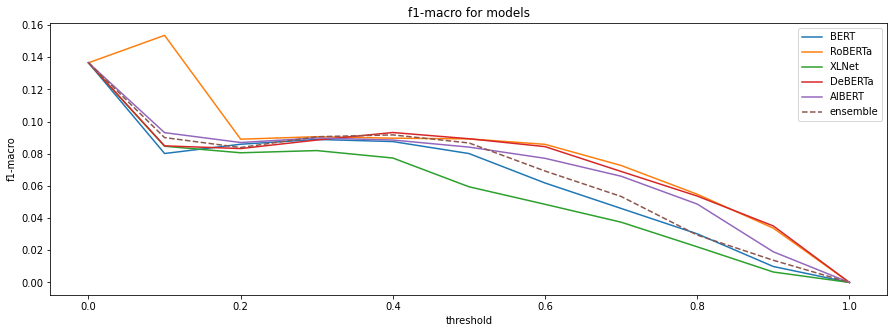

In [ ]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, macro_f1_bert, label="BERT")
plt.plot(thresholds, macro_f1_roberta, label="RoBERTa")
plt.plot(thresholds, macro_f1_xlnet, label="XLNet")
plt.plot(thresholds, macro_f1_deberta, label="DeBERTa")
plt.plot(thresholds, macro_f1_albert, label="AlBERT")
plt.plot(thresholds, macro_f1_ensemble, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-macro for models")
plt.xlabel("threshold")
plt.ylabel("f1-macro")

# TASK 3

In task 3, given a meme, we have to identify all techniques used in the meme, including the text and the visual content. Our approach takes heavy inspiration from the work of the AIMH group, presented in [this article](https://aclanthology.org/2021.semeval-1.140.pdf).  
There are two main differences between the model proposed by the authors and our implementation: the textual encoder used in our work is `DeBERTa`, instead of `BERT`, since it showed better performances in our earlier testing. Also we added dropout after the two transformers hoping to reduce overfitting.


In [ ]:
TASK = 3
transforms = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
NUM_LABELS = 22

## Datasets creation

### Finding mean and std for normalizing the images

In [ ]:
%%capture
transforms = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")
dataset_train_temp = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer, transforms=transforms
)
train_loader_temp = DataLoader(
    dataset_train_temp, batch_size=8, num_workers=2, pin_memory=True
)

# finding average and std of images
rgb_mean = []
rgb_var = []
for batch in train_loader_temp:
    _, _, _, images = batch
    rgb_mean.append(torch.mean(images, (0, 2, 3)))
    rgb_var.append(torch.square(torch.std(images, (0, 2, 3), unbiased=True)))
rgb_mean = torch.mean(torch.stack(rgb_mean), dim=0)
rgb_std = torch.sqrt(torch.mean(torch.stack(rgb_var), dim=0))

del tokenizer
del dataset_train_temp
del train_loader_temp

In [ ]:
print(rgb_mean)
print(rgb_std)

tensor([0.4695, 0.4162, 0.4042])
tensor([0.3170, 0.3070, 0.3074])


In [ ]:
transforms = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=rgb_mean, std=rgb_std),
    ]
)

### DeBERTa datasets

In [ ]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base", use_fast=True)
dataset_train3_DeBERTa = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer, transforms=transforms
)
train_loader_DeBERTa3 = DataLoader(
    dataset_train3_DeBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val3_DeBERTa = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer, transforms=transforms
)
val_loader_DeBERTa3 = DataLoader(
    dataset_val3_DeBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test3_DeBERTa = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer, transforms=transforms
)
test_loader_DeBERTa3 = DataLoader(
    dataset_test3_DeBERTa, batch_size=8, num_workers=2, pin_memory=True
)

### Looking at the data
We briefly look at the data. The tokenized versions of the texts have *max_length* (128) elements, like we expected. The labels are binarized correctly.

By looking a the whole dataset we see that it is not balanced, with some classes appearing much more frequently than others.  
In this case, differently from the task 1, in the data are also stored the images.

In [ ]:
print(dataset_train3_DeBERTa.input_ids[0])
label = dataset_train3_DeBERTa.y[0]
print(label)
print(my_binarizer_task3.inverse_transform(label.reshape(1, -1)))

tensor([    1,  3732, 23142, 10616, 35669, 34302,   272,  9309,  4322, 50118,
        50118,   597,  5330, 13812,  1437, 50118, 50118,   448, 13812, 50118,
            2,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

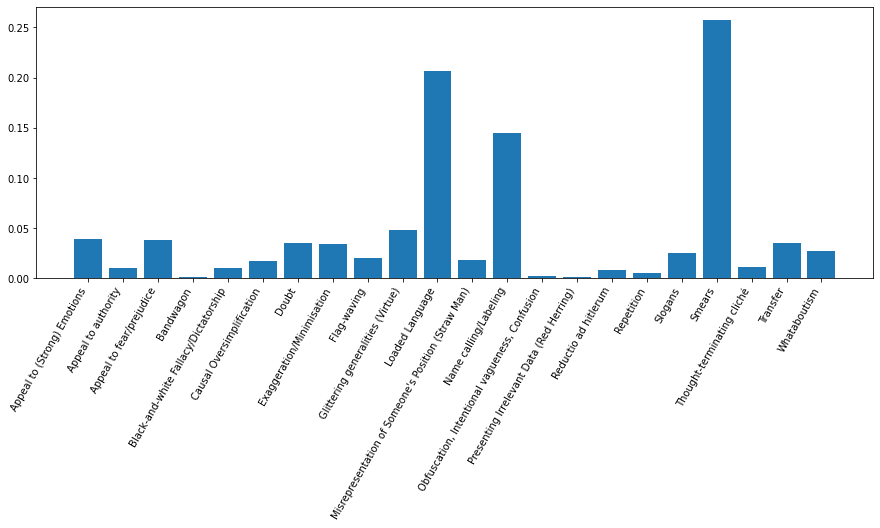

In [ ]:
label_dist = torch.sum(dataset_train3_DeBERTa.y, axis=0)
label_dist_norm_task3 = label_dist / torch.sum(label_dist)
fig = plt.figure(figsize=(15, 5))
plt.bar(labels_name3, label_dist_norm_task3)
plt.xticks(rotation=60, ha="right");

## Random baseline

We implemented two random baselines: the first one has probability of each label of a sample being one, equal to the fraction of samples having that label. The second baseline has probability 0.5 of each label being one.

In [ ]:
class random_baseline(pl.LightningModule):
    def __init__(self, data_dist):
        super().__init__()
        self.data_dist = data_dist

    def forward(self, x):
        rand = torch.rand(x.shape[0], self.data_dist.shape[0])
        return torch.less(rand, self.data_dist)

    def test_step(self, batch, batch_idx):
        x, mask, y, _ = batch
        y_hat = self(x)
        return y, y_hat

    def test(self, data_loader):
        true_labels = []
        predictions = []
        for i, batch in enumerate(data_loader):
            y, y_hat = self.test_step(batch, i)
            true_labels.append(y)
            predictions.append(y_hat)
        true_labels = torch.cat(true_labels)
        predictions = torch.cat(predictions)
        macro_f1 = f1_score(true_labels, predictions, average="macro", zero_division=1)
        micro_f1 = f1_score(true_labels, predictions, average="micro", zero_division=1)
        return macro_f1, micro_f1

In [ ]:
f1_macro = []
f1_micro = []
rb = random_baseline(label_dist_norm_task3)
for i in range(20):
    f1_macro_temp, f1_micro_temp = rb.test(train_loader_DeBERTa3)
    f1_macro.append(f1_macro_temp)
    f1_micro.append(f1_micro_temp)
print(
    "Random baseline \n  f1-macro %.5f+-%.5f\n  f1-micro %.5f+-%.5f"
    % (np.mean(f1_macro), np.std(f1_macro), np.mean(f1_micro), np.std(f1_micro))
)


f1_macro = []
f1_micro = []
rb2 = random_baseline(torch.ones(22) / 2)
for i in range(20):
    f1_macro_temp, f1_micro_temp = rb2.test(train_loader_DeBERTa3)
    f1_macro.append(f1_macro_temp)
    f1_micro.append(f1_micro_temp)
print(
    "Random baseline 2 \n  f1-macro %.5f+-%.5f\n  f1-micro %.5f+-%.5f"
    % (np.mean(f1_macro), np.std(f1_macro), np.mean(f1_micro), np.std(f1_micro))
)

Random baseline 
  f1-macro 0.06514+-0.00625
  f1-micro 0.20322+-0.01207
Random baseline 2 
  f1-macro 0.14694+-0.00378
  f1-micro 0.18814+-0.00440


## Baseline 2 - Visual and Textual models ensemble

As a second baseline we trained two networks: one using only the textual part of the sample and one only using the images. Then an ensemble that averages the two predictions is use as a classifier. 

### Visual Classifier
Image classifier for images using `ResNet50`.

In [ ]:
classifier = ImageClassifier()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Textual classifier

In [ ]:
deberta = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-base", num_labels=NUM_LABELS
)
model_deberta_task3 = PLMClassifier(deberta)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier

### Loading checkpoint

## Loading checkpoints
In this notebook pre-trained architectures are used, this way the notebook is neater and there are no problems of computational resources. Below you can look at the notebooks used for training the networks:

* Notebook 3  
<a href="https://github.com/Coerulatus/Detection-of-persuasive-techniques-in-memes/blob/main/training_notebooks/Training_Notebook3.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Notebook 1"/></a>

* Notebook 4  
<a href="https://github.com/Coerulatus/Detection-of-persuasive-techniques-in-memes/blob/main/training_notebooks/Training_Notebook4.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [ ]:
class ckpt_path:
    def __init__(self, path):
        self.best_model_path = path

checkpoint_callback6 = ckpt_path(
    "tb_logs/Image_classifier/version_0/checkpoints/IMAGE.ckpt"
)
checkpoint_callback7 = ckpt_path(
    "tb_logs/DeBERTaClassifier_task3/version_0/checkpoints/DEBERTA3.ckpt"
)
checkpoint_callback8 = ckpt_path(
    "tb_logs/DVTTClassifier/version_0/checkpoints/DVTT.ckpt"
)

print(checkpoint_callback6.best_model_path)
print(checkpoint_callback7.best_model_path)
print(checkpoint_callback8.best_model_path)

tb_logs/Image_classifier/version_0/checkpoints/IMAGE.ckpt
tb_logs/DeBERTaClassifier_task3/version_0/checkpoints/DEBERTA3.ckpt
tb_logs/DVTTClassifier/version_0/checkpoints/DVTT.ckpt


In [ ]:
%%capture
classifier.load_from_checkpoint(checkpoint_callback6.best_model_path)


model_deberta_task3.load_from_checkpoint(
    checkpoint_callback7.best_model_path, plm=deberta
)

### Visual and Textual classifier ensemble

In [ ]:
lv_ensemble = LanguageAndVisionEnsemble(model_deberta_task3, classifier)

## DVTT model

### Model definition

In [ ]:
model_dvtt = DoubleVisualTextualTransformer()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['deberta.encoder.layer.10.attention.output.dense.weight', 'deberta.encoder.layer.10.attention.output.LayerNorm.bias', 'deberta.encoder.layer.10.output.dense.weight', 'deberta.encoder.layer.11.attention.self.v_bias', 'lm_predictions.lm_head.dense.weight', 'deberta.encoder.layer.11.output.LayerNorm.bias', 'deberta.encoder.layer.11.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.11.intermediate.dense.bias', 'deberta.encoder.layer.10.intermediate.dense.weight', 'deberta.encoder.layer.10.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.10.attention.output.LayerNorm.weight', 'deberta.encoder.layer.10.output.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'deberta.encoder.layer.10.intermediate.dense.bias', 'deberta.encoder.layer.11.attention.self.q_bias', 'deberta.encoder.layer.11.attention.output.LayerNorm.bias', 'deberta.encoder.layer.11.output.dense.bias', 

In [ ]:
%%capture
# DVTT checkpoint
model_dvtt.load_from_checkpoint(checkpoint_callback8.best_model_path)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['deberta.encoder.layer.10.attention.output.dense.weight', 'deberta.encoder.layer.10.attention.output.LayerNorm.bias', 'deberta.encoder.layer.10.output.dense.weight', 'deberta.encoder.layer.11.attention.self.v_bias', 'lm_predictions.lm_head.dense.weight', 'deberta.encoder.layer.11.output.LayerNorm.bias', 'deberta.encoder.layer.11.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.11.intermediate.dense.bias', 'deberta.encoder.layer.10.intermediate.dense.weight', 'deberta.encoder.layer.10.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.10.attention.output.LayerNorm.weight', 'deberta.encoder.layer.10.output.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'deberta.encoder.layer.10.intermediate.dense.bias', 'deberta.encoder.layer.11.attention.self.q_bias', 'deberta.encoder.layer.11.attention.output.LayerNorm.bias', 'deberta.encoder.layer.11.output.dense.bias', 

## Testing model

### Testing function definition

In [ ]:
def test_classifier_lv(model, data_loader, thresholds, n_models=1):
    model.cuda()
    model.eval()
    micro_f1 = []
    macro_f1 = []
    outputs = []
    true_labels = []
    for i, batch in enumerate(data_loader):
        batch_ids, batch_mask, labels, batch_img = batch
        true_labels.append(labels)
        outputs.append(
            model(batch_ids.cuda(), batch_mask.cuda(), batch_img.cuda()).detach().cpu()
        )
    true_labels = torch.cat(true_labels)
    outputs = torch.cat(outputs)
    # print(outputs)
    for threshold in thresholds:
        predictions = torch.greater(outputs, torch.ones(outputs.shape) * threshold)
        # num_pred = [[1 if x else 0 for x in p] for p in predictions]
        # print(np.sum(num_pred,axis=0))
        macro_f1.append(
            f1_score(true_labels, predictions, average="macro", zero_division=1)
        )
        micro_f1.append(
            f1_score(true_labels, predictions, average="micro", zero_division=1)
        )

    return macro_f1, micro_f1

###Validation dataset performance

In [ ]:
thresholds = [x / 10 for x in range(0, 11)]

val_table = PrettyTable(["Model", "Micro F-1", "Macro F-1"])
val_table.title = "Validation set results"


macro_f1_lv_ens_val, micro_f1_lv_ens_val = test_classifier_lv(
    lv_ensemble, val_loader_DeBERTa3, thresholds
)
macro_f1_dvtt_val, micro_f1_dvtt_val = test_classifier_lv(
    model_dvtt, val_loader_DeBERTa3, thresholds
)

val_table.add_row(
    [
        "VT",
        str(format(max(micro_f1_lv_ens_val), ".5f")),
        str(format(max(macro_f1_lv_ens_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "DVTT",
        str(format(max(micro_f1_dvtt_val), ".5f")),
        str(format(max(macro_f1_dvtt_val), ".5f")),
    ]
)

print(val_table)

+-------------------------------+
|     Validation set results    |
+-------+-----------+-----------+
| Model | Micro F-1 | Macro F-1 |
+-------+-----------+-----------+
|   VT  |  0.50696  |  0.17554  |
|  DVTT |  0.24060  |  0.19920  |
+-------+-----------+-----------+


###Test dataset performance

In [ ]:
thresholds = [x / 10 for x in range(0, 11)]

test_table = PrettyTable(["Model", "Micro F-1", "Macro F-1"])
test_table.title = "Test set results"


macro_f1_lv_ens, micro_f1_lv_ens = test_classifier_lv(
    lv_ensemble, test_loader_DeBERTa3, thresholds
)
macro_f1_dvtt, micro_f1_dvtt = test_classifier_lv(
    model_dvtt, test_loader_DeBERTa3, thresholds
)

test_table.add_row(
    [
        "VT",
        str(format(max(micro_f1_lv_ens), ".5f")),
        str(format(max(macro_f1_lv_ens), ".5f")),
    ]
)
test_table.add_row(
    [
        "DVTT",
        str(format(max(micro_f1_dvtt), ".5f")),
        str(format(max(macro_f1_dvtt), ".5f")),
    ]
)

print(test_table)

+-------------------------------+
|        Test set results       |
+-------+-----------+-----------+
| Model | Micro F-1 | Macro F-1 |
+-------+-----------+-----------+
|   VT  |  0.39633  |  0.14378  |
|  DVTT |  0.21247  |  0.18767  |
+-------+-----------+-----------+


#Results

##TASK 1
Looking at the task 1 results in Table 1 and Table 2, fine-tuning the
`DeBERTa` model is even in this case a good choice. Also the ensemble of the 5 classifers achieves good results on the $Micro-F_1$ metric. All the models use the full power of the transformer architecture. In fact, in particular the second baseline, achieves good results using a simple architecture based on [bag of words](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) tokenization and a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model but our results are significantly better.

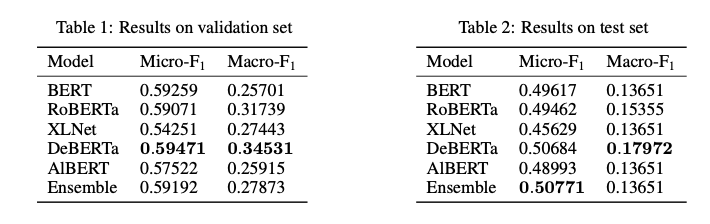

##TASK 3
Looking at the task 3 results in Table 3 and Table 4, we can
notice that the proposed `DVTT` model can achieve
slightly better results than the VT ensemble baseline. In
particular, the `DVTT` with fine-tuned `DeBERTa` and
`ResNet50` modules achieve the best results on the
$Micro-F_1$ metric.

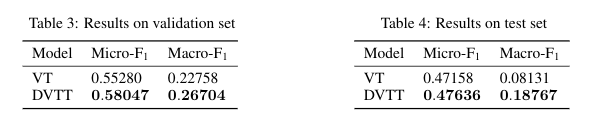